In [1]:
import time

import gym
import gym_snake
from ml_tools import q_learning

import numpy as np
import matplotlib.pyplot as plt

from ml_tools.ui import UI

ui = UI()
ui.connect("./public")

'127.0.0.1:53947'

In [12]:
# name = "pre-trained"
name = "pre-trained-more"
# name = "baseline"

load_pre_trained = True

In [18]:
from brain.v3.brain import Brain
from preprocessor import Preprocessor

preprocessor = Preprocessor()
preprocessor.ui = ui
brain = Brain(learning_rate=0.001)
brain.ui = ui


if load_pre_trained:
  brain.load_layers_and_compile_model(name=name, num_layers=6, trainable=False)
  print("")
else:
  brain.build_and_compile_model()

brain.model.summary()

Loaded layer
input_6
conv2d_10
max_pooling2d_10
conv2d_11
max_pooling2d_11
flatten_5

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 11, 11, 32)        6176      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 6, 6, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 2, 2, 64)          32832     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 2, 2, 64)         0         
 g2D)                                                            
                                       

In [19]:
agent = q_learning.Agent(
  action_space=[0, 1, 2, 3],

  brain=brain, preprocessor=preprocessor,

  epsilon_decay=0.99999,
  epsilon=1,
  
  discount_factor=0.97,
  
  replay_batch_size=32,
  model_batch_size=16,

  steps_to_train=20,
  steps_to_update_target=40,

  replay_memory_max_len=50_000,
  replay_memory_min_len= 2_000,
)

env = gym.make('snake-v0')

score = 0
scores = []
epsilons = []

game_num = 0

In [ ]:
raw_observation = env.reset()
agent.reset(raw_observation)

while True:
  if game_num == 10_000:
    break
    
  ui.video.update_stream("raw", raw_observation)

  speed = int(ui.control.get_value('speed') or 100)
  if speed != 100:
    time.sleep(1 / speed)

  agent.training = True if (ui.control.get_value('training') or 'true') == 'true' else False
  action = agent.act()
  raw_next_observation, reward, done, info = env.step(action)
  agent.step(reward, raw_next_observation)
  score += reward

  raw_observation = raw_next_observation
  if done:
    scores.append(score)
    epsilons.append(agent.epsilon)
    score = 0

    game_num += 1

    raw_observation = env.reset()
    agent.reset(raw_observation)

2/2 [==============================] - 0s 2ms/step - loss: 0.0023


2/2 [==============================] - 0s 4ms/step - loss: 0.0075


2/2 [==============================] - 0s 3ms/step - loss: 0.0110


2/2 [==============================] - 0s 3ms/step - loss: 0.0024


2/2 [==============================] - 0s 3ms/step - loss: 0.0063


2/2 [==============================] - 0s 2ms/step - loss: 0.0011


2/2 [==============================] - 0s 2ms/step - loss: 0.0022


2/2 [==============================] - 0s 5ms/step - loss: 6.9150e-04


2/2 [==============================] - 0s 2ms/step - loss: 0.0024


2/2 [==============================] - 0s 4ms/step - loss: 0.0232


2/2 [==============================] - 0s 2ms/step - loss: 0.0616


2/2 [==============================] - 0s 2ms/step - loss: 0.0014


2/2 [==============================] - 0s 2ms/step - loss: 0.0111


2/2 [==============================] - 0s 2ms/step - loss: 0.0130


2/2 [==============================] - 0s 2ms/step - loss: 0.0159


2/2 [==============================] - 0s 2ms/step - loss: 0.0604


2/2 [==============================] - 0s 4ms/step - loss: 0.0046


2/2 [==============================] - 0s 4ms/step - loss: 0.0070


2/2 [==============================] - 0s 2ms/step - loss: 0.0189


2/2 [==============================] - 0s 3ms/step - loss: 0.0015


2/2 [==============================] - 0s 2ms/step - loss: 0.0068


2/2 [==============================] - 0s 3ms/step - loss: 0.0028


2/2 [==============================] - 0s 2ms/step - loss: 0.0022


2/2 [==============================] - 0s 2ms/step - loss: 0.0040


2/2 [==============================] - 0s 2ms/step - loss: 0.0021


2/2 [==============================] - 0s 2ms/step - loss: 0.1115


2/2 [==============================] - 0s 2ms/step - loss: 0.0094


2/2 [==============================] - 0s 2ms/step - loss: 0.0080


2/2 [==============================] - 0s 2ms/step - loss: 0.0405


2/2 [==============================] - 0s 3ms/step - loss: 0.0041


2/2 [==============================] - 0s 3ms/step - loss: 0.0013


2/2 [==============================] - 0s 5ms/step - loss: 0.1038


2/2 [==============================] - 0s 2ms/step - loss: 0.1204


2/2 [==============================] - 0s 2ms/step - loss: 0.0185


2/2 [==============================] - 0s 2ms/step - loss: 0.0144


2/2 [==============================] - 0s 2ms/step - loss: 0.0023


2/2 [==============================] - 0s 2ms/step - loss: 0.0012


2/2 [==============================] - 0s 4ms/step - loss: 0.0194


2/2 [==============================] - 0s 3ms/step - loss: 0.0039


2/2 [==============================] - 0s 2ms/step - loss: 0.0260


2/2 [==============================] - 0s 2ms/step - loss: 0.0255


2/2 [==============================] - 0s 2ms/step - loss: 0.0030


2/2 [==============================] - 0s 3ms/step - loss: 0.0021


2/2 [==============================] - 0s 2ms/step - loss: 0.0013


2/2 [==============================] - 0s 2ms/step - loss: 0.0034


2/2 [==============================] - 0s 2ms/step - loss: 0.0222


2/2 [==============================] - 0s 3ms/step - loss: 0.0020


2/2 [==============================] - 0s 3ms/step - loss: 0.0040


2/2 [==============================] - 0s 2ms/step - loss: 0.0036


2/2 [==============================] - 0s 2ms/step - loss: 0.0013


2/2 [==============================] - 0s 2ms/step - loss: 0.0013


2/2 [==============================] - 0s 2ms/step - loss: 0.0116


2/2 [==============================] - 0s 2ms/step - loss: 0.0293


2/2 [==============================] - 0s 2ms/step - loss: 0.0337


2/2 [==============================] - 0s 2ms/step - loss: 0.0089


2/2 [==============================] - 0s 2ms/step - loss: 0.2464


2/2 [==============================] - 0s 2ms/step - loss: 0.0038


2/2 [==============================] - 0s 3ms/step - loss: 0.0402


2/2 [==============================] - 0s 2ms/step - loss: 0.0016


2/2 [==============================] - 0s 4ms/step - loss: 0.0716


2/2 [==============================] - 0s 2ms/step - loss: 0.0204


2/2 [==============================] - 0s 2ms/step - loss: 0.0032


2/2 [==============================] - 0s 4ms/step - loss: 0.0206


2/2 [==============================] - 0s 2ms/step - loss: 8.1561e-04


2/2 [==============================] - 0s 2ms/step - loss: 0.0112


2/2 [==============================] - 0s 2ms/step - loss: 0.0820


2/2 [==============================] - 0s 2ms/step - loss: 0.0051


2/2 [==============================] - 0s 2ms/step - loss: 0.0044


2/2 [==============================] - 0s 2ms/step - loss: 0.0098


2/2 [==============================] - 0s 2ms/step - loss: 0.0284


2/2 [==============================] - 0s 2ms/step - loss: 0.0012


2/2 [==============================] - 0s 2ms/step - loss: 0.0248


2/2 [==============================] - 0s 2ms/step - loss: 0.0138


2/2 [==============================] - 0s 2ms/step - loss: 0.0020


2/2 [==============================] - 0s 2ms/step - loss: 0.0021


2/2 [==============================] - 0s 2ms/step - loss: 0.0343


2/2 [==============================] - 0s 2ms/step - loss: 0.0203


2/2 [==============================] - 0s 2ms/step - loss: 0.0546


2/2 [==============================] - 0s 2ms/step - loss: 0.0021


2/2 [==============================] - 0s 2ms/step - loss: 0.3362


2/2 [==============================] - 0s 2ms/step - loss: 0.3652


2/2 [==============================] - 0s 2ms/step - loss: 0.0018


2/2 [==============================] - 0s 2ms/step - loss: 0.0104


2/2 [==============================] - 0s 2ms/step - loss: 5.7978e-04


2/2 [==============================] - 0s 2ms/step - loss: 0.0054


2/2 [==============================] - 0s 3ms/step - loss: 0.0036


2/2 [==============================] - 0s 2ms/step - loss: 0.0030


2/2 [==============================] - 0s 3ms/step - loss: 8.8605e-04


2/2 [==============================] - 0s 2ms/step - loss: 0.0029


2/2 [==============================] - 0s 3ms/step - loss: 0.0267


2/2 [==============================] - 0s 2ms/step - loss: 0.0020


2/2 [==============================] - 0s 2ms/step - loss: 0.0142


2/2 [==============================] - 0s 3ms/step - loss: 0.0022


2/2 [==============================] - 0s 2ms/step - loss: 0.0586


2/2 [==============================] - 0s 2ms/step - loss: 0.0088


2/2 [==============================] - 0s 2ms/step - loss: 2.6416e-04


2/2 [==============================] - 0s 2ms/step - loss: 1.9965e-04


2/2 [==============================] - 0s 2ms/step - loss: 9.9972e-04


2/2 [==============================] - 0s 3ms/step - loss: 0.0023


2/2 [==============================] - 0s 2ms/step - loss: 0.0244


2/2 [==============================] - 0s 3ms/step - loss: 0.0046


2/2 [==============================] - 0s 2ms/step - loss: 0.0081


2/2 [==============================] - 0s 3ms/step - loss: 0.0032


2/2 [==============================] - 0s 2ms/step - loss: 0.0080


2/2 [==============================] - 0s 2ms/step - loss: 0.0080


2/2 [==============================] - 0s 2ms/step - loss: 0.2088


2/2 [==============================] - 0s 2ms/step - loss: 0.0023


2/2 [==============================] - 0s 2ms/step - loss: 0.0065


2/2 [==============================] - 0s 2ms/step - loss: 0.0150


2/2 [==============================] - 0s 2ms/step - loss: 0.0421


2/2 [==============================] - 0s 2ms/step - loss: 0.0136


2/2 [==============================] - 0s 2ms/step - loss: 0.0149


2/2 [==============================] - 0s 2ms/step - loss: 0.0551


2/2 [==============================] - 0s 2ms/step - loss: 0.0724


2/2 [==============================] - 0s 2ms/step - loss: 0.1933


2/2 [==============================] - 0s 2ms/step - loss: 0.1147


2/2 [==============================] - 0s 2ms/step - loss: 0.0066


2/2 [==============================] - 0s 2ms/step - loss: 0.0138


2/2 [==============================] - 0s 2ms/step - loss: 0.0024


2/2 [==============================] - 0s 2ms/step - loss: 0.0061


2/2 [==============================] - 0s 2ms/step - loss: 0.0082


2/2 [==============================] - 0s 2ms/step - loss: 0.0091


2/2 [==============================] - 0s 2ms/step - loss: 0.0115


2/2 [==============================] - 0s 2ms/step - loss: 0.0549


2/2 [==============================] - 0s 2ms/step - loss: 0.0137


2/2 [==============================] - 0s 2ms/step - loss: 0.0033


2/2 [==============================] - 0s 2ms/step - loss: 0.0245


2/2 [==============================] - 0s 2ms/step - loss: 0.1057


2/2 [==============================] - 0s 2ms/step - loss: 0.0072


2/2 [==============================] - 0s 2ms/step - loss: 0.0034


2/2 [==============================] - 0s 2ms/step - loss: 0.0027


2/2 [==============================] - 0s 3ms/step - loss: 0.0061


2/2 [==============================] - 0s 2ms/step - loss: 0.0038


2/2 [==============================] - 0s 2ms/step - loss: 0.0075


2/2 [==============================] - 0s 2ms/step - loss: 0.0040


2/2 [==============================] - 0s 2ms/step - loss: 0.0012


2/2 [==============================] - 0s 2ms/step - loss: 0.0012


2/2 [==============================] - 0s 2ms/step - loss: 0.0115


2/2 [==============================] - 0s 2ms/step - loss: 0.0020


2/2 [==============================] - 0s 2ms/step - loss: 0.0025


2/2 [==============================] - 0s 3ms/step - loss: 0.0027


2/2 [==============================] - 0s 2ms/step - loss: 0.0026


2/2 [==============================] - 0s 2ms/step - loss: 0.0298


2/2 [==============================] - 0s 2ms/step - loss: 0.0100


2/2 [==============================] - 0s 2ms/step - loss: 0.0014


2/2 [==============================] - 0s 1ms/step - loss: 0.0085


2/2 [==============================] - 0s 2ms/step - loss: 0.0032


2/2 [==============================] - 0s 2ms/step - loss: 0.0020


2/2 [==============================] - 0s 2ms/step - loss: 0.0011


2/2 [==============================] - 0s 1ms/step - loss: 0.0254


2/2 [==============================] - 0s 1ms/step - loss: 0.1895


2/2 [==============================] - 0s 2ms/step - loss: 0.0059


2/2 [==============================] - 0s 2ms/step - loss: 0.0193


2/2 [==============================] - 0s 1ms/step - loss: 0.0096


2/2 [==============================] - 0s 1ms/step - loss: 0.1099


2/2 [==============================] - 0s 2ms/step - loss: 0.1652


2/2 [==============================] - 0s 2ms/step - loss: 0.0043


2/2 [==============================] - 0s 2ms/step - loss: 0.0030


2/2 [==============================] - 0s 1ms/step - loss: 0.0069


2/2 [==============================] - 0s 2ms/step - loss: 0.0554


2/2 [==============================] - 0s 2ms/step - loss: 0.0133


2/2 [==============================] - 0s 2ms/step - loss: 0.0071


2/2 [==============================] - 0s 1ms/step - loss: 0.0022


2/2 [==============================] - 0s 1ms/step - loss: 0.0103


2/2 [==============================] - 0s 2ms/step - loss: 0.0085


2/2 [==============================] - 0s 1ms/step - loss: 0.0044


2/2 [==============================] - 0s 2ms/step - loss: 0.0069


2/2 [==============================] - 0s 1ms/step - loss: 0.2293


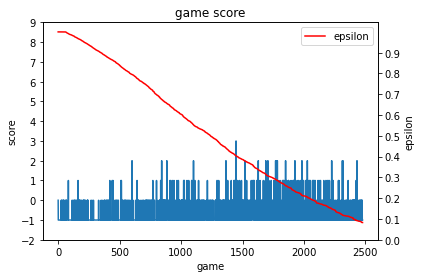

In [25]:
_, ax1 = plt.subplots()

plt.title('game score')
ax1.plot(scores)
ax1.set_xlabel('game')
ax1.set_ylabel('score')
ax1.set_yticks(np.arange(-2, 10, 1))

ax2 = ax1.twinx()
ax2.plot(epsilons, 'r')
ax2.set_ylabel('epsilon')
ax2.set_yticks(np.arange(0, 1, 0.1))
ax2.legend(['epsilon'], loc='upper right')

plt.savefig(f"{brain.current_folder}/{name}/game_score.jpg")
plt.show()

In [ ]:
brain.save_model()